<h3>Import data and select relevant columns</h3>

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

df.head()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
0,0,1,5,6,5,3,6,4,5,4,...,3,3,3,1,1,2,2,1,1,2
1,1,1,5,3,5,5,6,4,5,5,...,0,0,0,0,0,0,2,0,0,0
2,1,1,5,5,6,5,5,6,4,5,...,3,2,3,2,2,1,3,2,2,2
3,1,1,6,6,6,6,5,6,6,6,...,2,1,1,0,0,1,1,1,1,3
4,0,1,4,6,6,6,3,6,4,5,...,3,3,2,2,2,3,1,0,0,1


<h3>Data pre-processing</h3>

<h5>Synthetic Minority Over-sampling Technique (SMOTE)</h5>
<p>SMOTE works by creating new synthetic examples of the minority class by combining the attributes of existing minority class instances. It does this by selecting a minority class instance and finding its nearest neighbors. Then, it randomly selects one or more of these neighbors and creates new synthetic instances by randomly selecting features from the selected neighbors and the original instance. This process helps to expand the minority class and balance the dataset.</p>


<h5>Adaptive Synthetic Sampling (ADASYN)</h5>
<p>ADASYN is an extension of the SMOTE algorithm designed to address some of its limitations, particularly in scenarios where the distribution of the minority class is highly skewed or complex. ADASYN dynamically adjusts the importance of different minority class instances when generating synthetic samples, focusing more on samples that are harder to classify. It identifies the difficulty of classifying each minority class instance by measuring the density distribution around it. Instances that are harder to classify because they lie in low-density regions are given higher importance. Synthetic samples are then generated for each minority class instance, with the number of synthetic samples generated for each instance being proportional to its difficulty level. This adaptive nature makes ADASYN particularly useful in scenarios where the class imbalance is severe or where the minority class distribution is complex and non-linear.</p>

In [238]:
from imblearn.over_sampling import SMOTE, ADASYN
# gender split of the dataset
print(f"Gender split before balancing the dataset: {len(df[df['gender'] == 0])} women to {len(df[df['gender'] == 1])} men.")

Gender split before balancing the dataset: 177 women to 43 men.


In [240]:
# balance the dataset in regards to gender while keeping the same statistical properties
# Instantiate SMOTE
smote = SMOTE(k_neighbors=8, random_state=42)
adasyn = ADASYN(random_state=42)

X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0

<h5>Check whether SMOTE or ADASYN is better suited for balancing the dataset</h5>

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# oversample the training set using SMOTE
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# oversample the training set using ADASYN
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# train classifiers on balanced training sets
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_resampled_smote, y_resampled_smote)

rf_adasyn = RandomForestClassifier(random_state=42)
rf_adasyn.fit(X_resampled_adasyn, y_resampled_adasyn)

rf_og = RandomForestClassifier(random_state=42)
rf_og.fit(X_train, y_train)

# Evaluate classifiers on the original imbalanced test set
y_pred_smote = rf_smote.predict(X_test)
y_pred_adasyn = rf_adasyn.predict(X_test)
y_pred_og = rf_og.predict(X_test)

# Print classification reports to compare performance
print("Classification report for SMOTE-balanced classifier:")
print(classification_report(y_test, y_pred_smote))

print("\nClassification report for ADASYN-balanced classifier:")
print(classification_report(y_test, y_pred_adasyn))

print("\nClassification report for original classifier:")
print(classification_report(y_test, y_pred_og))

Classification report for SMOTE-balanced classifier:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        56
           1       0.30      0.30      0.30        10

    accuracy                           0.79        66
   macro avg       0.59      0.59      0.59        66
weighted avg       0.79      0.79      0.79        66


Classification report for ADASYN-balanced classifier:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        56
           1       0.43      0.30      0.35        10

    accuracy                           0.83        66
   macro avg       0.65      0.61      0.63        66
weighted avg       0.81      0.83      0.82        66


Classification report for original classifier:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        56
           1       0.00      0.00      0.00        10

    accuracy              

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN-balanced classifier seems to outperform the SMOTE-balanced one. Therefore from now one we will use the ADASYN-balanced dataset.

<h5>Apply ADASYN to balance the dataset</h5>

In [244]:
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
# gender split of the dataset
print(f"Gender split after balancing the dataset: {len(balanced_df[balanced_df['gender'] == 0])} women to {len(balanced_df[balanced_df['gender'] == 1])} men.")
balanced_df.describe()

Gender split after balancing the dataset: 177 women to 179 men.


,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.483146,3.553371,3.730337,4.797753,4.446629,3.904494,3.750000,3.334270,4.280899,...,1.561798,1.435393,1.311798,1.019663,0.772472,1.429775,1.629213,1.095506,1.039326,1.205056
std,0.500696,0.500419,1.585130,1.523628,1.421602,1.404205,1.529754,1.670582,1.696078,1.618476,...,1.006515,0.877760,0.952965,0.971223,0.826617,1.017099,0.962766,1.049148,1.047397,1.090330
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,3.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [321]:
# check if dataset was properly oversampled
#for col in balanced_df.columns:
#    print(set(balanced_df[col]))
balanced_df.head()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
0,0,1,5,6,5,3,6,4,5,4,...,3,3,3,1,1,2,2,1,1,2
1,1,1,5,3,5,5,6,4,5,5,...,0,0,0,0,0,0,2,0,0,0
2,1,1,5,5,6,5,5,6,4,5,...,3,2,3,2,2,1,3,2,2,2
3,1,1,6,6,6,6,5,6,6,6,...,2,1,1,0,0,1,1,1,1,3
4,0,1,4,6,6,6,3,6,4,5,...,3,3,2,2,2,3,1,0,0,1


<h3>Check for multicollinearity</h3>
<p>
Multicollinearity refers to a situation where two or more features are highly correlated. They provide the same or similar information about the target variable. This can cause problems when determining feature importance, as it can be hard to disentangle the effects of correlated features.

To avoid this, we can calculate the variance inflation factor (VIF) for each feature. A high VIF indicates that a feature is highly correlated with other features. If we find multicollinearity in the data we can remove one of the correlated features or merge two features into one.
</p>

In [291]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = balanced_df.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y = balanced_df['group'].copy() # adhd = 1 / no adhd = -1

def calculate_vif(X):
    # X - dataframe with independent features
    X_constant = add_constant(X)
    # calculate vif
    vif_vals = pd.DataFrame()
    vif_vals['var'] = X_constant.columns
    vif_vals['vif'] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
    
    return vif_vals[vif_vals['var'] != 'const'].sort_values(by='vif', ascending=False)

vif_results = calculate_vif(X)
# iterate until all VIF values are less than 5
while vif_results['vif'].max() > 5:
    # find the column with the highest VIF
    max_vif_column = vif_results.loc[vif_results['vif'].idxmax(), 'var']
    print(f'dropping {max_vif_column}')
    # Remove the column with the highest VIF
    X = X.drop(columns=[max_vif_column])
    # Recalculate VIF
    vif_results = calculate_vif(X)

vif_results.sort_values(by='vif', ascending=True)

dropping tr34
dropping tr12
dropping tr23
dropping tr3
dropping tr33
dropping tr22
dropping tr26
dropping tr24
dropping tr38
dropping tr1


,var,vif
15,tr18,2.023267
17,tr20,2.351265
9,tr11,2.396125
3,tr5,2.425564
25,tr32,2.481833
29,tr39,2.652056
10,tr13,2.845623
12,tr15,2.986584
2,tr4,3.022023
26,tr35,3.078564


In [384]:
cols_after_vif = vif_results['var'].tolist() + ['gender']
# selecting columns based on vif results - the remaining columns should be less correlated to each other 
X = balanced_df[cols_after_vif]
y = balanced_df['group']

<h3>Train, Test split of the balanced dataset</h3>
<p>
We split the dataset into train, test and validation sets, before scaling it to prevent data leakage. 
</p>

In [402]:
# split the balanced dataset 
X_balanced = X.copy()
y_balanced = y.copy() # adhd = 1 / no adhd = 0

In [401]:
# stratified splitting to preserve a balanced class split according to diagnosis
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, stratify=y, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42) 

In [404]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

# Step 3: Train your model using X_train_scaled and evaluate it using X_val_scaled
# After selecting the best model, you can evaluate its final performance on X_test_scaled

(240, 34)
(80, 34)
(36, 34)


<h3>Feature importance</h3>

<h5>Feature importance for the balanced dataset - mixed gender</h5>
<p>
Recursive Feature Elimination (RFE) is a feature selection technique that works by recursively removing features from the dataset and evaluating the performance of the model trained on the reduced feature set. It ranks the features based on their importance and eliminates the least important ones until the desired number of features is reached. </p>

In [371]:
num_features = 15
model = LogisticRegression()

rfe = RFE(model, n_features_to_select=num_features)
rfe.fit(X_train, y_train)

rfe_selected_features = X_train.columns[rfe.support_]
rfe_selected_features

Index(['tr28', 'tr8', 'tr36', 'tr17', 'tr41', 'tr6', 'tr14', 'tr19', 'tr40',
       'tr35', 'tr4', 'tr15', 'tr11', 'tr20', 'tr18'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix')

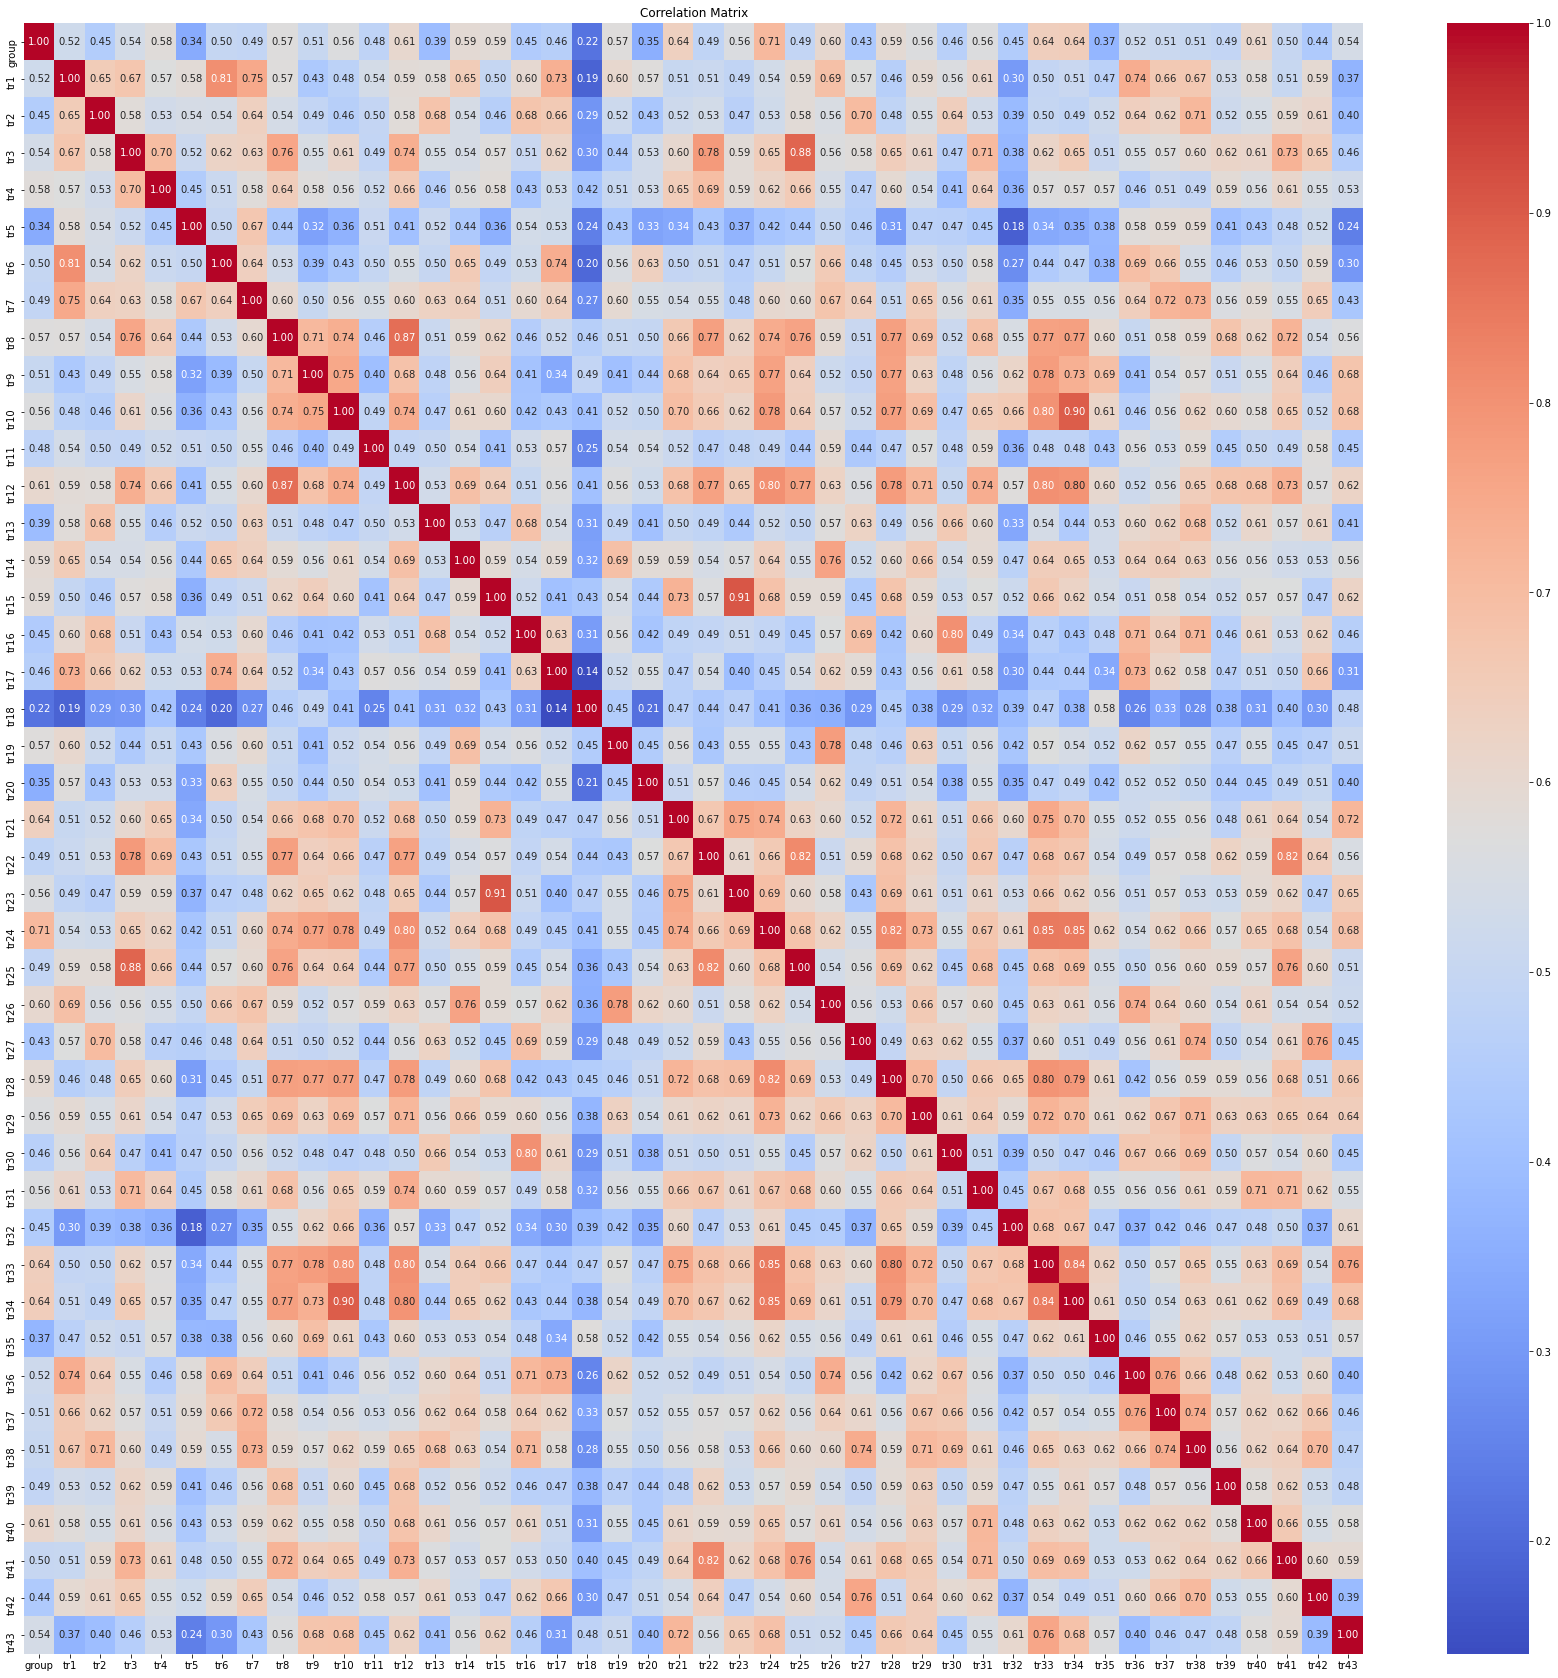

In [372]:
corr = balanced_df.filter(regex='tr|group').corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

['tr28', 'tr8', 'tr36', 'tr17', 'tr41', 'tr6', 'tr14', 'tr19', 'tr40', 'tr35', 'tr4', 'tr15', 'tr11', 'tr20', 'tr18', 'group']


Text(0.5, 1.0, 'Correlation Matrix')

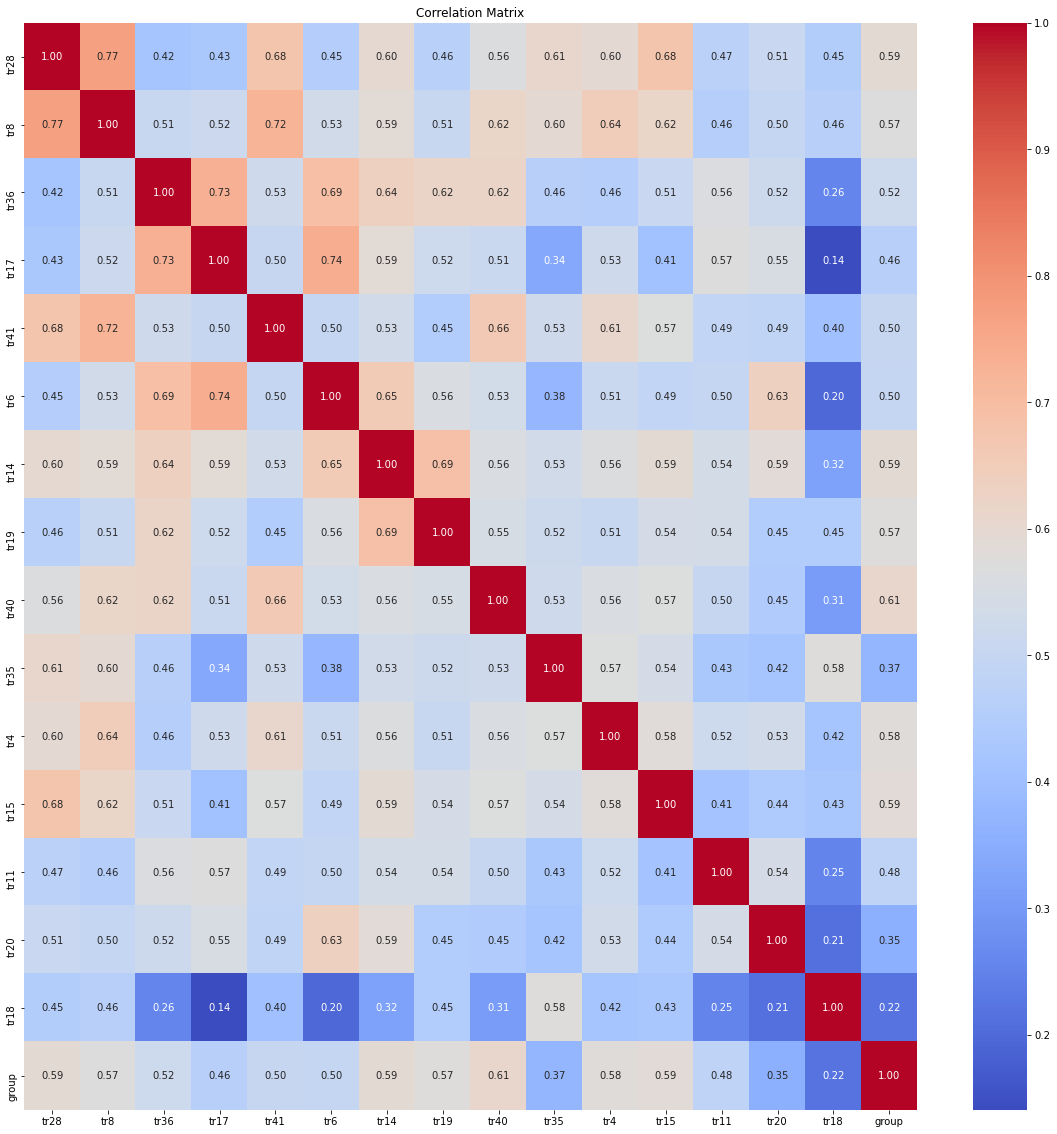

In [373]:
cols = rfe_selected_features.tolist() + ['group']
print(cols)
corr = balanced_df[cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')

['tr28', 'tr8', 'tr36', 'tr21', 'tr29', 'tr10', 'tr31', 'tr6', 'tr43', 'tr14', 'tr19', 'tr40', 'tr4', 'tr15', 'tr11', 'group']


Text(0.5, 1.0, 'Correlation Matrix')

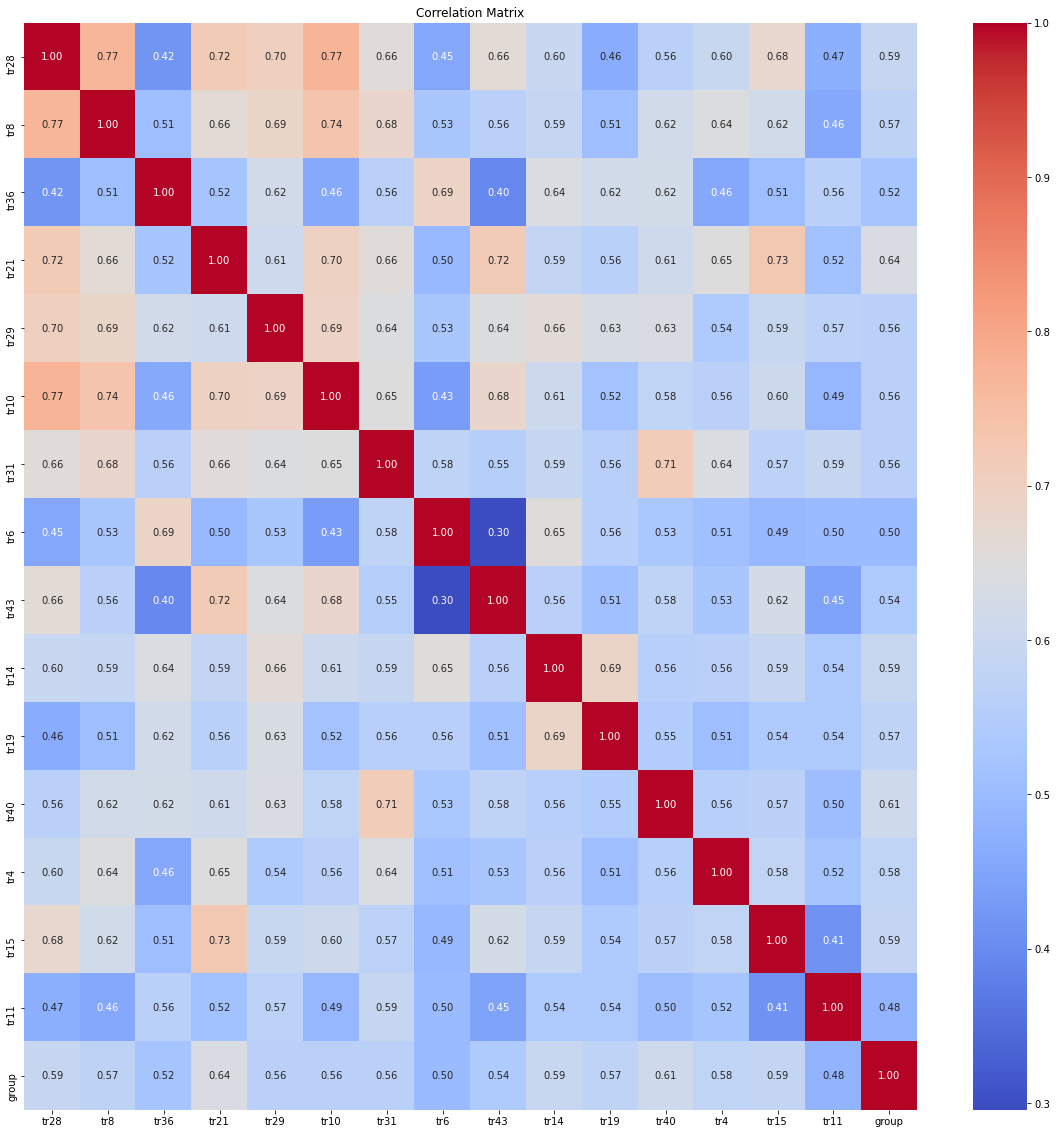

In [406]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Step 2: Select Features
# SelectKBest with ANOVA F-value can be used for feature selection
# Choose 'k' as the number of features you want to select
k_best_features = SelectKBest(score_func=f_classif, k=15)
X_selected = k_best_features.fit_transform(X_train, y_train)

selected_feature_indices = k_best_features.get_support(indices=True)
fval_selected_features = X_train.columns[selected_feature_indices]

cols = fval_selected_features.tolist() + ['group']
print(cols)
corr = balanced_df[cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')


In [407]:
overlapping_features = list(set(rfe_selected_features) & set(fval_selected_features))
overlapping_features

['tr28', 'tr36', 'tr4', 'tr40', 'tr6', 'tr15', 'tr11', 'tr14', 'tr19', 'tr8']

In [414]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Define evaluation metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation for RFE-selected features
rfe_scores = {}
for metric in scoring:
    scores = {}
    for clf_name, clf in classifiers.items():
        score = cross_val_score(clf, X_train[rfe_selected_features], y_train, cv=5, scoring=metric)
        scores[clf_name] = score.mean()
    rfe_scores[metric] = scores

# Perform cross-validation for F-anova-selected features
f_anova_scores = {}
for metric in scoring:
    scores = {}
    for clf_name, clf in classifiers.items():
        score = cross_val_score(clf, X_train[fval_selected_features], y_train, cv=5, scoring=metric)
        scores[clf_name] = score.mean()
    f_anova_scores[metric] = scores

# Print mean scores
print("Mean Scores for RFE-selected features:")
for metric, scores in rfe_scores.items():
    print(metric)
    for clf_name, score in scores.items():
        print(f"{clf_name}: {score:.4f}")
    print()

print("\nMean Scores for F-anova-selected features:")
for metric, scores in f_anova_scores.items():
    print(metric)
    for clf_name, score in scores.items():
        print(f"{clf_name}: {score:.4f}")
    print()


Mean Scores for RFE-selected features:
accuracy
Random Forest: 0.8750
SVM: 0.8667
Logistic Regression: 0.8583

precision
Random Forest: 0.8646
SVM: 0.8237
Logistic Regression: 0.8388

recall
Random Forest: 0.8960
SVM: 0.9221
Logistic Regression: 0.8790

f1
Random Forest: 0.8693
SVM: 0.8700
Logistic Regression: 0.8574


Mean Scores for F-anova-selected features:
accuracy
Random Forest: 0.8792
SVM: 0.8667
Logistic Regression: 0.8458

precision
Random Forest: 0.8840
SVM: 0.8253
Logistic Regression: 0.8274

recall
Random Forest: 0.8960
SVM: 0.9221
Logistic Regression: 0.8616

f1
Random Forest: 0.8854
SVM: 0.8706
Logistic Regression: 0.8439



<h5>Split the balanced dataset by gender for train, test sets</h5>

In [99]:
df_men = df[df['gender'] == 1]
df_women = df[df['gender'] == -1]

<h3>Feature Importance for women</h3>

In [91]:
X, y = df_women.drop(columns=['group']), df_women['group']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Univariate feature selection (SelectKBest with chi-square test)
k_best = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
print(k_best)
X_train_kbest = k_best.fit_transform(X_train, y_train)
selected_features_indices = k_best.get_support(indices=True)

# Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

# Print indices of selected features using univariate feature selection
print("Indices of selected features using SelectKBest:")
print(selected_features_indices)

# Print feature importances from Random Forest
print("\nFeature importances from Random Forest:")
print(importances)

SelectKBest(score_func=<function chi2 at 0x7fe6399698b0>)


ValueError: Input X must be non-negative.

In [89]:
X, y = X_resampled_adasyn, y_resampled_adasyn

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Univariate feature selection (SelectKBest with chi-square test)
k_best = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
print(k_best)
X_train_kbest = k_best.fit_transform(X_train, y_train)
selected_features_indices = k_best.get_support(indices=True)

# Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

# Print indices of selected features using univariate feature selection
print("Indices of selected features using SelectKBest:")
print(selected_features_indices)

# Print feature importances from Random Forest
print("\nFeature importances from Random Forest:")
print(importances)

SelectKBest(score_func=<function chi2 at 0x7fe6399698b0>)


ValueError: Input X must be non-negative.

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Select relevant features (e.g., symptoms demonstrating gender-specific patterns)
feature_cols = ['gender'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
y = X_resampled_adasyn['group']  # adhd = 1 / no-adhd = 0
X = X_resampled_adasyn[feature_cols]

# Engineer new features capturing distinct symptom presentation between women and men (if needed)

X_women = X_resampled_adasyn[X_resampled_adasyn['gender'] == 0]
y_women = X[X['gender'] == 0]
X_men = X[X['gender'] == 1]
y_men = X[X['gender'] == 1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection using SelectKBest with chi-square test
k_best = SelectKBest(score_func=chi2, k=15)  # Select top 10 features
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)
selected_features_indices = k_best.get_support(indices=True)
selected_features = X.columns[selected_features_indices]

print(selected_features)

# Model development and evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'AdaBoost': AdaBoostClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

for model_name, model in models.items():
    # Train model
    model.fit(X_train_kbest, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test_kbest)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_kbest, y_train, cv=5)
    print(f"  Cross-validation scores: {cv_scores}")
    print(f"  Mean CV accuracy: {cv_scores.mean()}")
    print()


Index(['tr14', 'tr15', 'tr19', 'tr23', 'tr24', 'tr26', 'tr27', 'tr29', 'tr31',
       'tr33', 'tr34', 'tr36', 'tr37', 'tr38', 'tr40'],
      dtype='object')
Logistic Regression:
  Accuracy: 0.8135593220338984
  Precision: 0.7777777777777778
  Recall: 0.8076923076923077
  F1-score: 0.7924528301886792
  Cross-validation scores: [0.82978723 0.93617021 0.80851064 0.85106383 0.89130435]
  Mean CV accuracy: 0.8633672525439409

AdaBoost:
  Accuracy: 0.864406779661017
  Precision: 0.875
  Recall: 0.8076923076923077
  F1-score: 0.8400000000000001
  Cross-validation scores: [0.87234043 0.91489362 0.87234043 0.87234043 0.93478261]
  Mean CV accuracy: 0.8933395004625346

Support Vector Machine:
  Accuracy: 0.847457627118644
  Precision: 0.7931034482758621
  Recall: 0.8846153846153846
  F1-score: 0.8363636363636363
  Cross-validation scores: [0.85106383 0.95744681 0.85106383 0.89361702 0.89130435]
  Mean CV accuracy: 0.8888991674375578

Random Forest:
  Accuracy: 0.8983050847457628
  Precision: 0.9